In [1]:
import sys
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
import skimage.data as skd
from scipy.misc import imresize
from PIL import Image
import selectivesearch 
import matplotlib.patches as mpatches
from collections import OrderedDict
import IPython.display as display
%matplotlib inline


In [59]:
class FeaturesExtractor(nn.Module):
    
        def __init__(self, input_features, layer_idx=12): # 1, 4, 7, 9, 12
            
            super(FeaturesExtractor, self).__init__()
            mods = OrderedDict()

            for i in range(0, layer_idx):
                mods[ str(i)] = copy.deepcopy(input_features[i])
                
            self.features = nn.Sequential(mods)           
            
        def forward(self, input):
            return self.features(input)

In [3]:
import copy

class FeaturesExtractorAP(nn.Module):
    
        def __init__(self, input_features, layer_idx=12): # 1, 4, 7, 9, 12
            
            super(FeaturesExtractorAP, self).__init__()
            mods = OrderedDict()

            for i in range(0, layer_idx):
                mods[ str(i)] = copy.deepcopy(input_features[i])
                
            self.features = nn.Sequential(mods)
            
            for idx, module in self.features._modules.items():
                if module.__class__.__name__ is 'MaxPool2d':
                    self.features._modules[idx] = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))            
            
        def forward(self, input):
            return self.features(input)

In [6]:
def show_img(img, cmap=None):
    _, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img, cmap=cmap)
    plt.show()

In [7]:
VGG16 = models.vgg16(pretrained=True)
VGG16.eval

<bound method Module.eval of VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_s

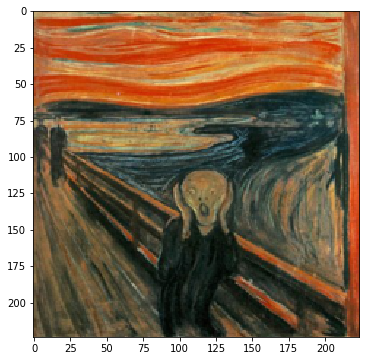

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 512, 14, 14])


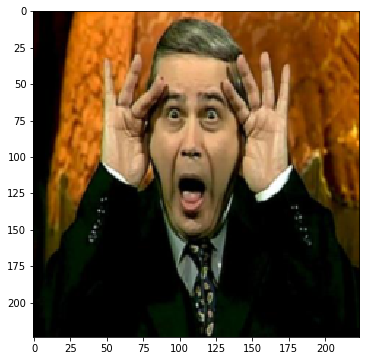

torch.Size([1, 512, 28, 28])


In [83]:
def get_G(img, layer_idx):
    img = imresize(img, [224, 224]) / 255
    show_img(img)
    in_img = torch.from_numpy(img).transpose(2,1).transpose(1,0).unsqueeze(0).float()
    in_img = Variable(in_img)
    Gs = []
    for i in [0, 5, 10, 17, 24]:
        if i >= layer_idx:
            break
        features_extractor = FeaturesExtractorAP(VGG16.features, i + 1)
            
        
        out = features_extractor(in_img)
        print(out.size())
        out = out[0].view(out.size()[1], out.size()[2]**2)
        out = torch.matmul(out, out.transpose(0, 1))
        Gs.append(out)
    return Gs

def get_F(img, layer_idx):
    img = imresize(img, [224, 224]) / 255
    show_img(img)
    in_img = torch.from_numpy(img ).transpose(2,1).transpose(1,0).unsqueeze(0).float()
    in_img = Variable(in_img)
    Fs = []
    for i in [19]:
        if i >= layer_idx:
            break
        features_extractor = FeaturesExtractorAP(VGG16.features, i + 1)
            
        
        out = features_extractor(in_img)
        print(out.size())
    return out
    
img_scream = np.asarray(Image.open('./img/scream.jpg'))
img_evgeniy = np.asarray(Image.open('./img/evgeniy.jpg'))
scream_G = get_G(img_scream, 25)
evgeniy_F = get_F(img_evgeniy, 20)

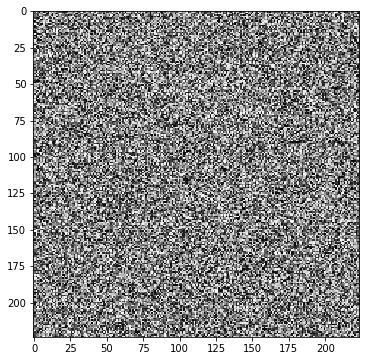

In [84]:
rand_in_img = Variable( torch.rand(1, 1, 224, 224), requires_grad=True)
rand_in_img = torch.cat((rand_in_img, rand_in_img, rand_in_img), 1)
#rand_in_img = Variable( torch.from_numpy(imresize(img_evgeniy, [224, 224]) / 255).transpose(2,1).transpose(1,0).unsqueeze(0).float(), requires_grad=True)

show_img(rand_in_img[0].transpose(0,1).transpose(1,2).data.numpy())

In [85]:
def transfer(Gs, Fs, layer_idx, input_img):
    in_img = Variable(input_img.data, requires_grad=True)
    
    Fs = Fs.cuda()
    for i in range(len(Gs)):
        Gs[i] = Gs[i].cuda()
    f_extractors = []
    for i in [0, 5, 10, 17, 24]:
        if i >= layer_idx:
            break
        f_extractors.append(FeaturesExtractorAP(VGG16.features, i + 1).cuda())
    c_extractor = FeaturesExtractorAP(VGG16.features, 19 + 1).cuda()
    
    optimizer = torch.optim.Adam([in_img], lr=1e-1)
    
    for n_iter in range(0, 1000):
        optimizer.zero_grad()
        G_loss = 0
        
        for i in range(len(f_extractors)):
            out = f_extractors[i](in_img.cuda())
            N = out.size()[1]
            M = out.size()[2]
            G = out[0].view(N, M**2)
            G = torch.matmul(G, G.transpose(0, 1))
            G_loss += ((Gs[i] - G)**2).sum()/(4 * N**2 * M**2)/5
        
        
        out = c_extractor(in_img.cuda())
        N = out.size()[1]
        M = out.size()[2]
        
        F=out
        F_loss = (Fs - F).view(1, -1)
        F_loss = torch.matmul(F_loss, F_loss.transpose(0, 1))[0] / 2
        
        loss = F_loss + 10000*G_loss
        sys.stdout.write('\riter: %d, total loss: %.3f, G loss: %.3f, F loss: %.3f'%(n_iter, loss.data[0], G_loss.data[0], F_loss.data[0]))

        loss.backward(retain_graph=True)
        optimizer.step()
        in_img.data.clamp_(0,1)
        if n_iter % 100 == 0:
            show_img(in_img[0].transpose(0,1).transpose(1,2).data.numpy())
    return in_img

5
22
4
iter: 0, total loss: 93528272.000, G loss: 9283.748, F loss: 690789.062

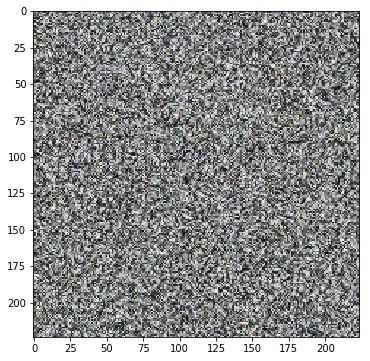

iter: 100, total loss: 379997.625, G loss: 12.192, F loss: 258075.93825

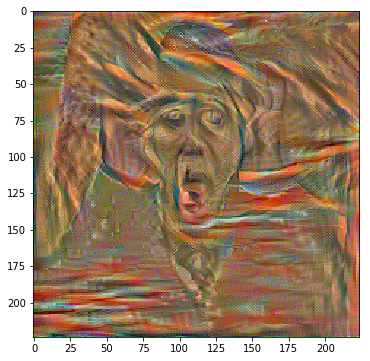

iter: 200, total loss: 277266.875, G loss: 8.540, F loss: 191862.5624

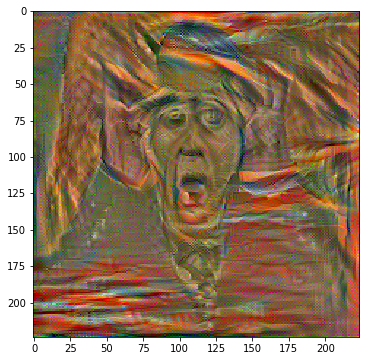

iter: 300, total loss: 252559.312, G loss: 7.582, F loss: 176741.500

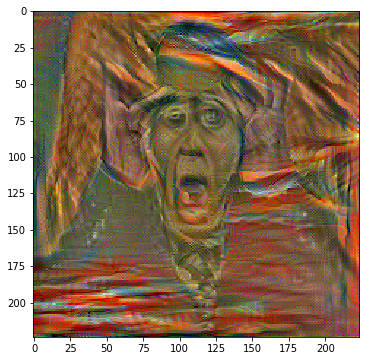

iter: 400, total loss: 241011.500, G loss: 7.284, F loss: 168167.812

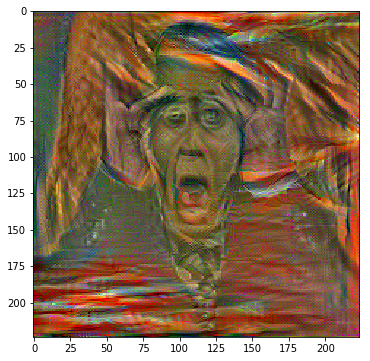

iter: 500, total loss: 232816.156, G loss: 7.166, F loss: 161154.953

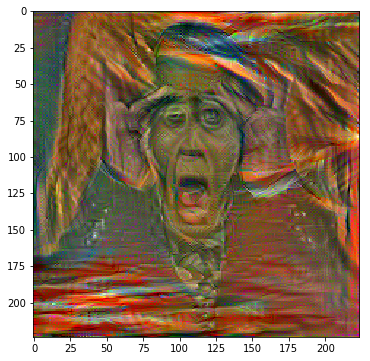

iter: 600, total loss: 231843.906, G loss: 6.981, F loss: 162029.203

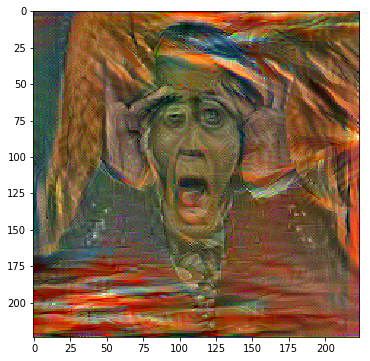

iter: 700, total loss: 225572.062, G loss: 7.022, F loss: 155353.438

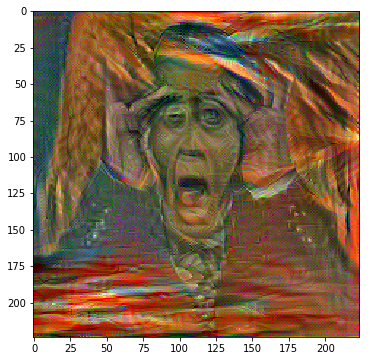

iter: 800, total loss: 232523.500, G loss: 7.034, F loss: 162179.031

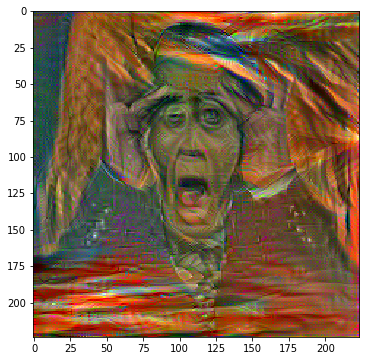

iter: 900, total loss: 231665.281, G loss: 7.003, F loss: 161631.906

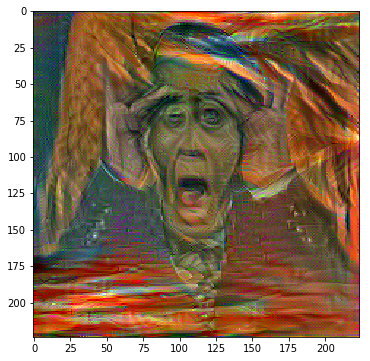

iter: 999, total loss: 233644.000, G loss: 7.613, F loss: 157515.016

In [86]:
result = transfer(scream_G, evgeniy_F, 23, rand_in_img)

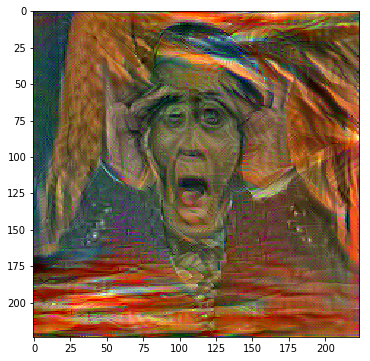

In [87]:
show_img(result[0].transpose(0,1).transpose(1,2).data.numpy())